In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score, recall_score, precision_score

import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
trainingset_path = '../dataset/training-set.csv'
testingset_path = '../dataset/testing-set.csv'

In [3]:
train_claim_df = pd.read_csv('../dataset/train_claim_df.csv', encoding='utf-8')
test_claim_df = pd.read_csv('../dataset/test_claim_df.csv', encoding='utf-8')
#train_renew_df = pd.read_csv('../dataset/train_only_renew.csv', encoding='utf-8')
trainingset_df = pd.read_csv(trainingset_path, encoding='utf-8')
testingset_df = pd.read_csv(testingset_path, encoding='utf-8')

In [4]:
train_renew_df = train_claim_df[train_claim_df['Next_Premium'] != 0].copy()
train_no_renew_df = train_claim_df[train_claim_df['Next_Premium'] == 0].copy()

In [5]:
train_claim_data = train_claim_df.iloc[:, 2:]
train_label = train_claim_df.iloc[:, 1]

train_renew_data = train_renew_df.iloc[:, 2:]
train_renew_label = train_renew_df.iloc[:, 1]
train_no_renew_data = train_no_renew_df.iloc[:, 2:]
train_no_renew_label = train_no_renew_df.iloc[:, 1]

test_claim_data = test_claim_df.iloc[:, 2:]

In [6]:
ss_x = StandardScaler()
ss_x.fit_transform(train_claim_data)
ss_y = StandardScaler()
ss_y.fit_transform(train_label.reshape(-1, 1))

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.0926244 ],
       [ 0.43511441],
       [ 0.14749538],
       ...,
       [ 1.05716133],
       [-0.28386413],
       [ 0.01134926]])

In [7]:
print(train_claim_data.shape)
print(train_label.shape)
print(train_renew_data.shape)
print(train_renew_label.shape)
print(train_no_renew_data.shape)
print(train_no_renew_label.shape)
print(test_claim_data.shape)

(210763, 41)
(210763,)
(164553, 41)
(164553,)
(46210, 41)
(46210,)
(140510, 41)


# classified model

In [8]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
import lightgbm as lgb
from sklearn.svm import SVC

In [9]:
train_no_renew_data['renew'] = 0
train_renew_data['renew'] = 1

In [10]:
train_renew_data_sample = train_renew_data.sample(n=46210, axis=0, random_state=7)

In [11]:
train_renew_data_sample.shape

(46210, 42)

In [12]:
all_train_renew_data = pd.concat([train_renew_data_sample, train_no_renew_data], axis=0)
all_train_renew_data.head()

,Cancellation,Manafactured_Year_and_Month,Engine_Displacement_(Cubic_Centimeter),qpt,Main_Insurance_Coverage_Group_0,Main_Insurance_Coverage_Group_1,Main_Insurance_Coverage_Group_2,Coverage_Deductible_if_applied,Coverage_Deductible_if_applied_percent,Premium,...,Accident_date,Paid_Loss_Amount,paid_Expenses_Amount,Salvage_or_Subrogation?,At_Fault?,"Claim_Status_(close,_open,_reopen_etc)",Deductible,number_of_claimants,Insured_Amount,renew
100797,0,2014,2400,5.0,5,2,3,0,1,17798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59625500,1
158308,0,2009,1200,2.0,3,1,2,0,1,6904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4645000,1
37851,1,2009,1598,5.0,6,0,1,0,0,7833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46677000,1
2986,1,2005,2349,5.0,2,1,2,0,1,13837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3561000,1
59933,0,2011,2378,5.0,4,3,2,0,1,8062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23861000,1


In [13]:
x_train_re, x_val_re, y_train_re, y_val_re = train_test_split(all_train_renew_data.iloc[:,:-1], all_train_renew_data.iloc[:,-1], test_size=0.2, random_state = 7, shuffle=True)
print(x_train_re.shape)
print(y_train_re.shape)
print(x_val_re.shape)
print(y_val_re.shape)

(73936, 41)
(73936,)
(18484, 41)
(18484,)


In [14]:
x_train_re = ss_x.transform(x_train_re)
x_val_re = ss_x.transform(x_val_re)

In [15]:
import time
#setting the checkpoint dir and checkpoint model name
parent_path = os.path.abspath("..")
save_dir = os.path.join(parent_path, 'checkpoints/')
model_name = time.strftime('class_%m%d_%H_%M_%S.h5')

In [22]:
nn_model = Sequential()
nn_model.add(Dense(16, input_dim=41, kernel_initializer='normal', activation='relu'))
nn_model.add(BatchNormalization())
# nn_model.add(Dense(8, kernel_initializer='normal', activation='relu'))
# nn_model.add(BatchNormalization())
nn_model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model
opt = keras.optimizers.Adam(lr=0.01)
nn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [23]:
earlystop = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
model_history = nn_model.fit(x_train_re, y_train_re, validation_data=(x_val_re, y_val_re), batch_size=500, epochs=100, shuffle=True,
                            callbacks=[checkpoint])

Train on 73936 samples, validate on 18484 samples
Epoch 1/100
73936/73936 [==============================] - 2s 22us/step - loss: 0.6415 - acc: 0.6185 - val_loss: 0.6287 - val_acc: 0.6398

Epoch 00001: val_loss improved from inf to 0.62874, saving model to D:\fang\AI_proj\tbrain_policy\checkpoints/class_0827_09_27_35.h5
Epoch 2/100
73936/73936 [==============================] - 1s 18us/step - loss: 0.6207 - acc: 0.6358 - val_loss: 0.6179 - val_acc: 0.6409

Epoch 00002: val_loss improved from 0.62874 to 0.61785, saving model to D:\fang\AI_proj\tbrain_policy\checkpoints/class_0827_09_27_35.h5
Epoch 3/100
73936/73936 [==============================] - 1s 19us/step - loss: 0.6156 - acc: 0.6381 - val_loss: 0.6209 - val_acc: 0.6378

Epoch 00003: val_loss did not improve
Epoch 4/100
73936/73936 [==============================] - 1s 19us/step - loss: 0.6141 - acc: 0.6412 - val_loss: 0.6178 - val_acc: 0.6403

Epoch 00004: val_loss improved from 0.61785 to 0.61781, saving model to D:\fang\AI_pro


Epoch 00040: val_loss improved from 0.60649 to 0.60521, saving model to D:\fang\AI_proj\tbrain_policy\checkpoints/class_0827_09_27_35.h5
Epoch 41/100
73936/73936 [==============================] - 1s 17us/step - loss: 0.6001 - acc: 0.6500 - val_loss: 0.6095 - val_acc: 0.6418

Epoch 00041: val_loss did not improve
Epoch 42/100
73936/73936 [==============================] - 1s 17us/step - loss: 0.5994 - acc: 0.6507 - val_loss: 0.6063 - val_acc: 0.6416

Epoch 00042: val_loss did not improve
Epoch 43/100
73936/73936 [==============================] - 1s 17us/step - loss: 0.6022 - acc: 0.6512 - val_loss: 0.6078 - val_acc: 0.6450

Epoch 00043: val_loss did not improve
Epoch 44/100
73936/73936 [==============================] - 1s 17us/step - loss: 0.6000 - acc: 0.6497 - val_loss: 0.6063 - val_acc: 0.6437

Epoch 00044: val_loss did not improve
Epoch 45/100
73936/73936 [==============================] - 1s 17us/step - loss: 0.6004 - acc: 0.6502 - val_loss: 0.6071 - val_acc: 0.6452

Epoch 0004


Epoch 00084: val_loss did not improve
Epoch 85/100
73936/73936 [==============================] - 1s 17us/step - loss: 0.5974 - acc: 0.6515 - val_loss: 0.6100 - val_acc: 0.6413

Epoch 00085: val_loss did not improve
Epoch 86/100
73936/73936 [==============================] - 1s 19us/step - loss: 0.5976 - acc: 0.6526 - val_loss: 0.6046 - val_acc: 0.6455

Epoch 00086: val_loss did not improve
Epoch 87/100
73936/73936 [==============================] - 1s 17us/step - loss: 0.5980 - acc: 0.6520 - val_loss: 0.6049 - val_acc: 0.6414

Epoch 00087: val_loss did not improve
Epoch 88/100
73936/73936 [==============================] - 1s 17us/step - loss: 0.5979 - acc: 0.6524 - val_loss: 0.6063 - val_acc: 0.6456

Epoch 00088: val_loss did not improve
Epoch 89/100
73936/73936 [==============================] - 1s 17us/step - loss: 0.5972 - acc: 0.6531 - val_loss: 0.6059 - val_acc: 0.6417

Epoch 00089: val_loss did not improve
Epoch 90/100
73936/73936 [==============================] - 1s 17us/ste

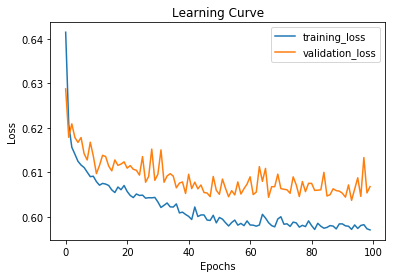

In [24]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [25]:
from keras.models import load_model
best_nn_model = load_model('../checkpoints/class_0827_09_27_35.h5')

In [26]:
y_pred_nn = best_nn_model.predict(ss_x.transform(test_claim_data))

### xgb

In [27]:
num_rounds = 5000
params = {
    'eta': 0.01,
    'objective': 'binary:logistic',
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 1.1,
    'max_depth': 7,
}
xgtrain = xgb.DMatrix(x_train_re, label=y_train_re)
#求出最佳num_rounds
cvresult = xgb.cv(params, xgtrain, num_boost_round=num_rounds, nfold=5, metrics='error', seed=0,
                  callbacks=[xgb.callback.print_evaluation(show_stdv=False), xgb.callback.early_stop(50)])
num_round_best = cvresult.shape[0] - 1
print('Best round num: ', num_round_best)

[0]	train-error:0.353546	test-error:0.361867
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 50 rounds.
[1]	train-error:0.349583	test-error:0.358783
[2]	train-error:0.346584	test-error:0.355889
[3]	train-error:0.345394	test-error:0.354861
[4]	train-error:0.343496	test-error:0.354888
[5]	train-error:0.343111	test-error:0.354564
[6]	train-error:0.343588	test-error:0.354428
[7]	train-error:0.343053	test-error:0.35455
[8]	train-error:0.342032	test-error:0.354103
[9]	train-error:0.341566	test-error:0.353535
[10]	train-error:0.341265	test-error:0.353143
[11]	train-error:0.341288	test-error:0.35267
[12]	train-error:0.34067	test-error:0.352602
[13]	train-error:0.340727	test-error:0.353224
[14]	train-error:0.340612	test-error:0.352372
[15]	train-error:0.340436	test-error:0.352589
[16]	train-error:0.340704	test-error:0.352886
[17]	train-error:0.340284	test-error:0.352237
[18]	train-error:0.340558	test-error:0.3

[175]	train-error:0.330982	test-error:0.349748
[176]	train-error:0.330861	test-error:0.349897
[177]	train-error:0.33085	test-error:0.349924
[178]	train-error:0.330769	test-error:0.350059
[179]	train-error:0.330701	test-error:0.349884
[180]	train-error:0.330675	test-error:0.34987
[181]	train-error:0.330617	test-error:0.349789
[182]	train-error:0.330576	test-error:0.349762
[183]	train-error:0.330536	test-error:0.349816
[184]	train-error:0.330472	test-error:0.349735
[185]	train-error:0.330333	test-error:0.349789
[186]	train-error:0.330286	test-error:0.349735
[187]	train-error:0.330252	test-error:0.349667
[188]	train-error:0.330137	test-error:0.349654
[189]	train-error:0.33011	test-error:0.349613
[190]	train-error:0.330019	test-error:0.349721
[191]	train-error:0.329954	test-error:0.349478
[192]	train-error:0.32989	test-error:0.349518
[193]	train-error:0.329914	test-error:0.349572
[194]	train-error:0.329897	test-error:0.349491
[195]	train-error:0.329728	test-error:0.349518
[196]	train-error

In [28]:
best_param = {
    'n_estimators': num_round_best,
    'eta': 0.01,
    'objective': 'binary:logistic',
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 1.1,
    'max_depth': 7,
}
best_model = xgb.XGBClassifier(**best_param)

In [29]:
print('Training...')
best_model.fit(x_train_re, y_train_re)

Training...


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.01, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1.1, missing=None,
       n_estimators=202, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)

In [30]:
y_pred_val = best_model.predict(x_val_re)

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [31]:
f1_score(y_pred_val, y_val_re)

0.6899748889318138

In [32]:
accuracy_score(y_pred_val, y_val_re)

0.6526725816922744

In [33]:
recall_score(y_pred_val, y_val_re)

0.6236033519553073

In [34]:
precision_score(y_pred_val, y_val_re)

0.7721573713791613

In [35]:
y_pred_xgb = best_model.predict(ss_x.transform(test_claim_data))

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### GB

In [52]:
GBoost = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01,
                                   max_depth=7, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='deviance', random_state =5)

In [53]:
GBoost.fit(x_train_re,y_train_re)
y_pred_GBoost = GBoost.predict(x_val_re)

In [54]:
f1_score(y_pred_GBoost, y_val_re)

0.6924763993515781

In [55]:
accuracy_score(y_pred_GBoost, y_val_re)

0.6510495563730794

In [56]:
recall_score(y_pred_GBoost, y_val_re)

0.6195188534379799

In [57]:
precision_score(y_pred_GBoost, y_val_re)

0.7849113705144833

In [58]:
y_pred_GB = GBoost.predict(ss_x.transform(test_claim_data))

### RF

In [59]:
RF = RandomForestClassifier(n_estimators=2000,
                            max_depth=5,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            bootstrap=True, oob_score=False, n_jobs=1, random_state=7, verbose=0, warm_start=False, class_weight=None)

In [60]:
RF.fit(x_train_re,y_train_re)
y_pred_RF = RF.predict(x_val_re)

In [61]:
f1_score(y_pred_RF, y_val_re)

0.6909090909090909

In [62]:
accuracy_score(y_pred_RF, y_val_re)

0.6449902618480848

In [63]:
recall_score(y_pred_RF, y_val_re)

0.6122891968609117

In [64]:
precision_score(y_pred_RF, y_val_re)

0.7926934716817985

In [65]:
y_pred_RF = RF.predict(ss_x.transform(test_claim_data))

### lgb

In [67]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'binary', 

    'learning_rate': 0.01, 
    'num_leaves': 80, 
    'max_depth': 10,
    'min_child_samples': 22,
    'min_child_weight': 0.001,
    'bagging_fraction': 0.6,
    'feature_fraction': 0.75,

    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    }

In [74]:
data_train = lgb.Dataset(x_train_re, y_train_re, silent=True)
cv_results = lgb.cv(params, data_train, num_boost_round=5000, nfold=5, stratified=False, shuffle=True,
                    metrics='auc',early_stopping_rounds=30, verbose_eval=100, show_stdv=True, seed=0)

print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', cv_results['auc-mean'][-1])

[100]	cv_agg's auc: 0.709134 + 0.00124974
[200]	cv_agg's auc: 0.710786 + 0.00135635
[300]	cv_agg's auc: 0.711676 + 0.00137517
[400]	cv_agg's auc: 0.712296 + 0.00128624
[500]	cv_agg's auc: 0.712581 + 0.00127616
[600]	cv_agg's auc: 0.712701 + 0.00124824
best n_estimators: 575
best cv score: 0.7127212447215724


In [75]:
best_lgb_model = lgb.LGBMRegressor(objective='binary',num_leaves=80, min_child_samples=22, min_child_weight=0.001, 
                                   bagging_fraction=0.6, feature_fraction=0.75, 
                                   learning_rate=0.01, n_estimators=575, max_depth=10,
                                   metric='auc',subsample=0.8, colsample_bytree=0.8, )

In [76]:
print('Training...')
best_lgb_model.fit(x_train_re, y_train_re)
print('Predicting...')
y_pred_lgb = best_lgb_model.predict(x_val_re)

Training...
Predicting...


In [82]:
y_pred_RF[:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

In [81]:
y_pred_lgb = y_pred_lgb

array([0.00434432, 0.52707988, 0.00667602, 0.00602231, 0.52417674,
       0.34254184, 0.37003961, 0.00833697, 0.53074158, 0.59412496])

In [77]:
f1_score(y_pred_lgb, y_val_re)

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [53]:
accuracy_score(y_pred_lgb, y_val_re)

0.6277320926206449

In [54]:
recall_score(y_pred_lgb, y_val_re)

0.6206124732933157

In [55]:
precision_score(y_pred_lgb, y_val_re)

0.6593169044530912

In [84]:
y_pred_lgb = best_lgb_model.predict(ss_x.transform(test_claim_data))

# Ensemble class

In [121]:
class_result = pd.DataFrame({'nn':y_pred_nn.reshape(-1), 'GBOOST': y_pred_GB, 'XGB': y_pred_xgb, 'RF':y_pred_RF, 'lgb':y_pred_lgb})

In [122]:
class_result.iloc[class_result[class_result['nn'] > 0.3].index, 4] = 1
class_result.iloc[class_result[class_result['nn'] < 0.3].index, 4] = 0
class_result.iloc[class_result[class_result['lgb'] > 0.3].index, 3] = 1
class_result.iloc[class_result[class_result['lgb'] < 0.3].index, 3] = 0

In [123]:
class_result

,GBOOST,RF,XGB,lgb,nn
0,1,1,1,1.0,1.0
1,0,0,0,1.0,1.0
2,0,1,0,1.0,1.0
3,1,1,1,1.0,1.0
4,1,1,1,1.0,1.0
5,1,1,1,1.0,1.0
6,1,1,1,1.0,1.0
7,0,0,0,0.0,0.0
8,1,1,1,1.0,1.0
9,1,1,1,1.0,1.0


In [92]:
class_result['sum'] = (class_result.GBOOST + class_result.XGB + class_result.nn + class_result.RF + class_result.lgb)/5

In [94]:
class_result.iloc[class_result[class_result['sum'] > 0.5].index, 5] = 1
class_result.iloc[class_result[class_result['sum'] < 0.5].index, 5] = 0

In [124]:
class_result['nn'].sum()

127335.0

In [125]:
class_result.lgb.sum()

129030.0

In [126]:
class_result.RF.sum()

99035

# Regression model

In [100]:
train_regression = ss_x.transform(train_renew_data.iloc[:,:-1])
train_regression_label = ss_y.transform(train_renew_label.reshape(-1, 1))

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [101]:
x_trian_regression, x_val_regression, y_train_regression, y_val_regression = train_test_split(train_regression, train_regression_label, test_size=0.2, random_state = 7, shuffle=True)
print(x_trian_regression.shape)
print(y_train_regression.shape)
print(x_val_regression.shape)
print(y_val_regression.shape)

(131642, 41)
(131642, 1)
(32911, 41)
(32911, 1)


In [102]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression_l1', 

    'learning_rate': 0.01, 
    'num_leaves': 80, 
    'max_depth': 10,
    'min_child_samples': 22,
    'min_child_weight': 0.001,
    'bagging_fraction': 0.6,
    'feature_fraction': 0.75,

    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    }

In [103]:
data_train = lgb.Dataset(x_trian_regression, y_train_regression.reshape(-1), silent=True)
cv_results = lgb.cv(params, data_train, num_boost_round=5000, nfold=5, stratified=False, shuffle=True,
                    metrics='mae',early_stopping_rounds=30, verbose_eval=100, show_stdv=True, seed=0)

print('best n_estimators:', len(cv_results['l1-mean']))
print('best cv score:', cv_results['l1-mean'][-1])

[100]	cv_agg's l1: 0.295977 + 0.00639797
[200]	cv_agg's l1: 0.195814 + 0.00360844
[300]	cv_agg's l1: 0.155319 + 0.00237232
[400]	cv_agg's l1: 0.138438 + 0.00198027
[500]	cv_agg's l1: 0.131345 + 0.00182762
[600]	cv_agg's l1: 0.1285 + 0.00184462
[700]	cv_agg's l1: 0.127137 + 0.00187269
[800]	cv_agg's l1: 0.126198 + 0.00184118
[900]	cv_agg's l1: 0.12554 + 0.00179175
[1000]	cv_agg's l1: 0.125085 + 0.00172492
[1100]	cv_agg's l1: 0.12475 + 0.00170848
[1200]	cv_agg's l1: 0.124501 + 0.0016685
[1300]	cv_agg's l1: 0.124318 + 0.00165237
[1400]	cv_agg's l1: 0.12419 + 0.00164521
[1500]	cv_agg's l1: 0.124066 + 0.00163856
[1600]	cv_agg's l1: 0.123958 + 0.00164965
[1700]	cv_agg's l1: 0.123842 + 0.00166849
[1800]	cv_agg's l1: 0.123763 + 0.00166096
[1900]	cv_agg's l1: 0.123693 + 0.00165332
[2000]	cv_agg's l1: 0.123624 + 0.00161871
[2100]	cv_agg's l1: 0.123571 + 0.00160833
[2200]	cv_agg's l1: 0.123537 + 0.00158258
[2300]	cv_agg's l1: 0.123503 + 0.0015299
[2400]	cv_agg's l1: 0.123458 + 0.00153994
[2500]	c

In [104]:
reg_lgb_model = lgb.LGBMRegressor(objective='regression_l1',num_leaves=80, min_child_samples=22, min_child_weight=0.001, 
                                   bagging_fraction=0.6, feature_fraction=0.75, 
                                   learning_rate=0.01, n_estimators=3011, max_depth=10,
                                   metric='mae',subsample=0.8, colsample_bytree=0.8, )

In [105]:
print('Training...')
reg_lgb_model.fit(x_trian_regression, y_train_regression)
print('Predicting...')
y_reg_lgb = ss_y.inverse_transform(reg_lgb_model.predict(ss_x.transform(test_claim_data)))

Training...


C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Predicting...


In [128]:
class_result['reg_lgb'] = y_reg_lgb

### ReG NN

In [74]:
reg_model = Sequential()
reg_model.add(Dense(100, input_dim=70, kernel_initializer='normal', activation='relu'))
reg_model.add(Dense(1, kernel_initializer='normal'))
# Compile model
opt = keras.optimizers.Adam(lr=0.01)
reg_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mae'])

In [75]:
earlystop = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
model_path = os.path.join(save_dir, time.strftime('reg_%m%d_%H_%M_%S.h5'))
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
model_history = reg_model.fit(x_trian_regression, y_train_regression, validation_data=(x_val_regression, y_val_regression), batch_size=1000, epochs=500, shuffle=True,
                            callbacks=[checkpoint])

Train on 131642 samples, validate on 32911 samples
Epoch 1/500
131642/131642 [==============================] - 1s 6us/step - loss: 0.1821 - mean_absolute_error: 0.1821 - val_loss: 0.1451 - val_mean_absolute_error: 0.1451

Epoch 00001: val_loss improved from inf to 0.14514, saving model to D:\fang\AI_proj\tbrain_policy\checkpoints/reg_0816_17_40_19.h5
Epoch 2/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1399 - mean_absolute_error: 0.1399 - val_loss: 0.1403 - val_mean_absolute_error: 0.1403

Epoch 00002: val_loss improved from 0.14514 to 0.14027, saving model to D:\fang\AI_proj\tbrain_policy\checkpoints/reg_0816_17_40_19.h5
Epoch 3/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1347 - mean_absolute_error: 0.1347 - val_loss: 0.1344 - val_mean_absolute_error: 0.1344

Epoch 00003: val_loss improved from 0.14027 to 0.13442, saving model to D:\fang\AI_proj\tbrain_policy\checkpoints/reg_0816_17_40_19.h5
Epoch 4/500
131642/131642 [=====


Epoch 00033: val_loss did not improve
Epoch 34/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1264 - mean_absolute_error: 0.1264 - val_loss: 0.1265 - val_mean_absolute_error: 0.1265

Epoch 00034: val_loss did not improve
Epoch 35/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1250 - mean_absolute_error: 0.1250 - val_loss: 0.1271 - val_mean_absolute_error: 0.1271

Epoch 00035: val_loss did not improve
Epoch 36/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1263 - mean_absolute_error: 0.1263 - val_loss: 0.1264 - val_mean_absolute_error: 0.1264

Epoch 00036: val_loss did not improve
Epoch 37/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1244 - mean_absolute_error: 0.1244 - val_loss: 0.1281 - val_mean_absolute_error: 0.1281

Epoch 00037: val_loss did not improve
Epoch 38/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1254 - mean_absolute_error: 0.125


Epoch 00070: val_loss did not improve
Epoch 71/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1238 - mean_absolute_error: 0.1238 - val_loss: 0.1280 - val_mean_absolute_error: 0.1280

Epoch 00071: val_loss did not improve
Epoch 72/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1236 - mean_absolute_error: 0.1236 - val_loss: 0.1292 - val_mean_absolute_error: 0.1292

Epoch 00072: val_loss did not improve
Epoch 73/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1238 - mean_absolute_error: 0.1238 - val_loss: 0.1276 - val_mean_absolute_error: 0.1276

Epoch 00073: val_loss did not improve
Epoch 74/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1234 - mean_absolute_error: 0.1234 - val_loss: 0.1297 - val_mean_absolute_error: 0.1297

Epoch 00074: val_loss did not improve
Epoch 75/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1244 - mean_absolute_error: 0.124


Epoch 00109: val_loss did not improve
Epoch 110/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1231 - mean_absolute_error: 0.1231 - val_loss: 0.1256 - val_mean_absolute_error: 0.1256

Epoch 00110: val_loss did not improve
Epoch 111/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1225 - mean_absolute_error: 0.1225 - val_loss: 0.1267 - val_mean_absolute_error: 0.1267

Epoch 00111: val_loss did not improve
Epoch 112/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1229 - mean_absolute_error: 0.1229 - val_loss: 0.1267 - val_mean_absolute_error: 0.1267

Epoch 00112: val_loss did not improve
Epoch 113/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1225 - mean_absolute_error: 0.1225 - val_loss: 0.1255 - val_mean_absolute_error: 0.1255

Epoch 00113: val_loss did not improve
Epoch 114/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1227 - mean_absolute_error: 

Epoch 186/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1217 - mean_absolute_error: 0.1217 - val_loss: 0.1266 - val_mean_absolute_error: 0.1266

Epoch 00186: val_loss did not improve
Epoch 187/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1226 - mean_absolute_error: 0.1226 - val_loss: 0.1249 - val_mean_absolute_error: 0.1249

Epoch 00187: val_loss did not improve
Epoch 188/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1211 - mean_absolute_error: 0.1211 - val_loss: 0.1278 - val_mean_absolute_error: 0.1278

Epoch 00188: val_loss did not improve
Epoch 189/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1215 - mean_absolute_error: 0.1215 - val_loss: 0.1263 - val_mean_absolute_error: 0.1263

Epoch 00189: val_loss did not improve
Epoch 190/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1221 - mean_absolute_error: 0.1221 - val_loss: 0.1251 - val_mean_ab


Epoch 00223: val_loss did not improve
Epoch 224/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1216 - mean_absolute_error: 0.1216 - val_loss: 0.1247 - val_mean_absolute_error: 0.1247

Epoch 00224: val_loss did not improve
Epoch 225/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1215 - mean_absolute_error: 0.1215 - val_loss: 0.1260 - val_mean_absolute_error: 0.1260

Epoch 00225: val_loss did not improve
Epoch 226/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1210 - mean_absolute_error: 0.1210 - val_loss: 0.1250 - val_mean_absolute_error: 0.1250

Epoch 00226: val_loss did not improve
Epoch 227/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1216 - mean_absolute_error: 0.1216 - val_loss: 0.1244 - val_mean_absolute_error: 0.1244

Epoch 00227: val_loss did not improve
Epoch 228/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1212 - mean_absolute_error: 

131642/131642 [==============================] - 1s 5us/step - loss: 0.1221 - mean_absolute_error: 0.1221 - val_loss: 0.1251 - val_mean_absolute_error: 0.1251

Epoch 00262: val_loss did not improve
Epoch 263/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1213 - mean_absolute_error: 0.1213 - val_loss: 0.1242 - val_mean_absolute_error: 0.1242

Epoch 00263: val_loss did not improve
Epoch 264/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1215 - mean_absolute_error: 0.1215 - val_loss: 0.1250 - val_mean_absolute_error: 0.1250

Epoch 00264: val_loss did not improve
Epoch 265/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1213 - mean_absolute_error: 0.1213 - val_loss: 0.1246 - val_mean_absolute_error: 0.1246

Epoch 00265: val_loss did not improve
Epoch 266/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1214 - mean_absolute_error: 0.1214 - val_loss: 0.1239 - val_mean_absolute_error: 


Epoch 00338: val_loss did not improve
Epoch 339/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1206 - mean_absolute_error: 0.1206 - val_loss: 0.1278 - val_mean_absolute_error: 0.1278

Epoch 00339: val_loss did not improve
Epoch 340/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1213 - mean_absolute_error: 0.1213 - val_loss: 0.1259 - val_mean_absolute_error: 0.1259

Epoch 00340: val_loss did not improve
Epoch 341/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1211 - mean_absolute_error: 0.1211 - val_loss: 0.1253 - val_mean_absolute_error: 0.1253

Epoch 00341: val_loss did not improve
Epoch 342/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1210 - mean_absolute_error: 0.1210 - val_loss: 0.1264 - val_mean_absolute_error: 0.1264

Epoch 00342: val_loss did not improve
Epoch 343/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1210 - mean_absolute_error: 


Epoch 00415: val_loss did not improve
Epoch 416/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1213 - mean_absolute_error: 0.1213 - val_loss: 0.1257 - val_mean_absolute_error: 0.1257

Epoch 00416: val_loss did not improve
Epoch 417/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1215 - mean_absolute_error: 0.1215 - val_loss: 0.1251 - val_mean_absolute_error: 0.1251

Epoch 00417: val_loss did not improve
Epoch 418/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1209 - mean_absolute_error: 0.1209 - val_loss: 0.1264 - val_mean_absolute_error: 0.1264

Epoch 00418: val_loss did not improve
Epoch 419/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1208 - mean_absolute_error: 0.1208 - val_loss: 0.1258 - val_mean_absolute_error: 0.1258

Epoch 00419: val_loss did not improve
Epoch 420/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1204 - mean_absolute_error: 


Epoch 00492: val_loss did not improve
Epoch 493/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1209 - mean_absolute_error: 0.1209 - val_loss: 0.1263 - val_mean_absolute_error: 0.1263

Epoch 00493: val_loss did not improve
Epoch 494/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1201 - mean_absolute_error: 0.1201 - val_loss: 0.1256 - val_mean_absolute_error: 0.1256

Epoch 00494: val_loss did not improve
Epoch 495/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1207 - mean_absolute_error: 0.1207 - val_loss: 0.1260 - val_mean_absolute_error: 0.1260

Epoch 00495: val_loss did not improve
Epoch 496/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1208 - mean_absolute_error: 0.1208 - val_loss: 0.1257 - val_mean_absolute_error: 0.1257

Epoch 00496: val_loss did not improve
Epoch 497/500
131642/131642 [==============================] - 1s 5us/step - loss: 0.1209 - mean_absolute_error: 

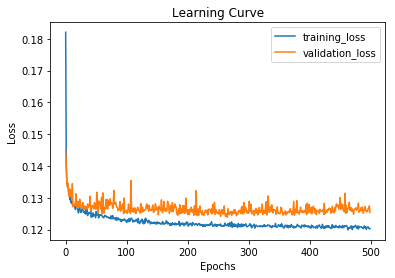

In [76]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [77]:
from keras.models import load_model
best_reg_model = load_model('../checkpoints/reg_0816_17_40_19.h5')

In [78]:
y_pred_nn_reg = best_reg_model.predict(ss_x.transform(test_claim_data))

In [79]:
class_result['reg_nn'] = ss_y.inverse_transform(y_pred_nn_reg)

In [129]:
class_result.iloc[class_result[class_result['lgb'] == 0].index, -1] = 0

In [87]:
super_score = pd.read_csv('../result_csv/15/super_weight_815_1598.csv', encoding='utf-8')

In [88]:
class_result['super'] = super_score['Next_Premium']

In [130]:
class_result

,GBOOST,RF,XGB,lgb,nn,reg_lgb
0,1,1,1,1.0,1.0,3305.553831
1,0,0,0,1.0,1.0,1850.044457
2,0,1,0,1.0,1.0,3177.210880
3,1,1,1,1.0,1.0,6000.660550
4,1,1,1,1.0,1.0,3144.411715
5,1,1,1,1.0,1.0,10645.941083
6,1,1,1,1.0,1.0,20721.577997
7,0,0,0,0.0,0.0,0.000000
8,1,1,1,1.0,1.0,4093.423686
9,1,1,1,1.0,1.0,9173.705424


In [102]:
class_result['res'] = class_result.reg - class_result.super

In [99]:
class_result.iloc[class_result[class_result['sum'] == 0].index, -2] = 0

In [104]:
class_result.iloc[class_result[(class_result['res'] > 3000) | (class_result['res'] < -3000)].index, -3] = class_result['super']

In [105]:
class_result

,GBOOST,RF,XGB,nn,svm,sum,reg,super,res
0,1,1,1,1.0,1,1.0,3455.581787,3227.854870,227.726917
1,0,0,0,0.0,0,0.0,0.000000,0.000000,0.000000
2,0,1,0,1.0,0,0.0,0.000000,0.000000,0.000000
3,1,1,1,1.0,1,1.0,6081.053223,6031.602276,49.450947
4,1,1,1,1.0,1,1.0,3286.188721,3117.252210,168.936511
5,1,1,1,1.0,1,1.0,9428.345703,10009.806770,-581.461067
6,1,1,1,1.0,0,1.0,20229.033203,20229.033500,-3217.023734
7,0,0,0,0.0,1,0.0,0.000000,0.000000,0.000000
8,1,1,1,1.0,1,1.0,4011.476807,3892.345975,119.130832
9,1,1,1,1.0,1,1.0,9163.248047,9070.434670,92.813377


In [131]:
#result to csv
submit = testingset_df.copy()
submit['Next_Premium'] = class_result['reg_lgb']
submit.to_csv('../result_csv/two_827.csv', sep=',', index=None)